In [1]:
#untuk bisa mendownload langsung dari kaggle, langkah awal adalah mount drive kita
#karena nantinya hasil download akan disimpan disana

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#sebelum run code ini, buatlah folder Kaggle pada My Drive, dan taruh kaggle.json
#kaggle.json akan membantu untuk mendownload datasets dari kaggle hanya berdasarkan API yang bisa di copy

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [3]:
#Apabila belum pernah menginstall kaggle, maka perlu dijalankan
!pip install -q kaggle

#Mendownload datasets dan akan tersimpan di folder /My Drive/Kaggle/
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

#pastikan terdapat kaggle.json di folder Kaggle, karena jika tidak maka akan terjadi error
#cara mendapatkannya adalah buka kaggle, lalu download API nya

 77% 5.00M/6.47M [00:00<00:00, 22.8MB/s]
100% 6.47M/6.47M [00:00<00:00, 25.6MB/s]


In [4]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

#karena semua file yang didonload di kaggle, akan berbentuk zip
#maka unzip file nya

Archive:  health-insurance-cross-sell-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import numpy as np
import pandas as pd

pima = pd.read_csv("train.csv")

In [6]:
pima

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


Penjelasan mengenai column-column

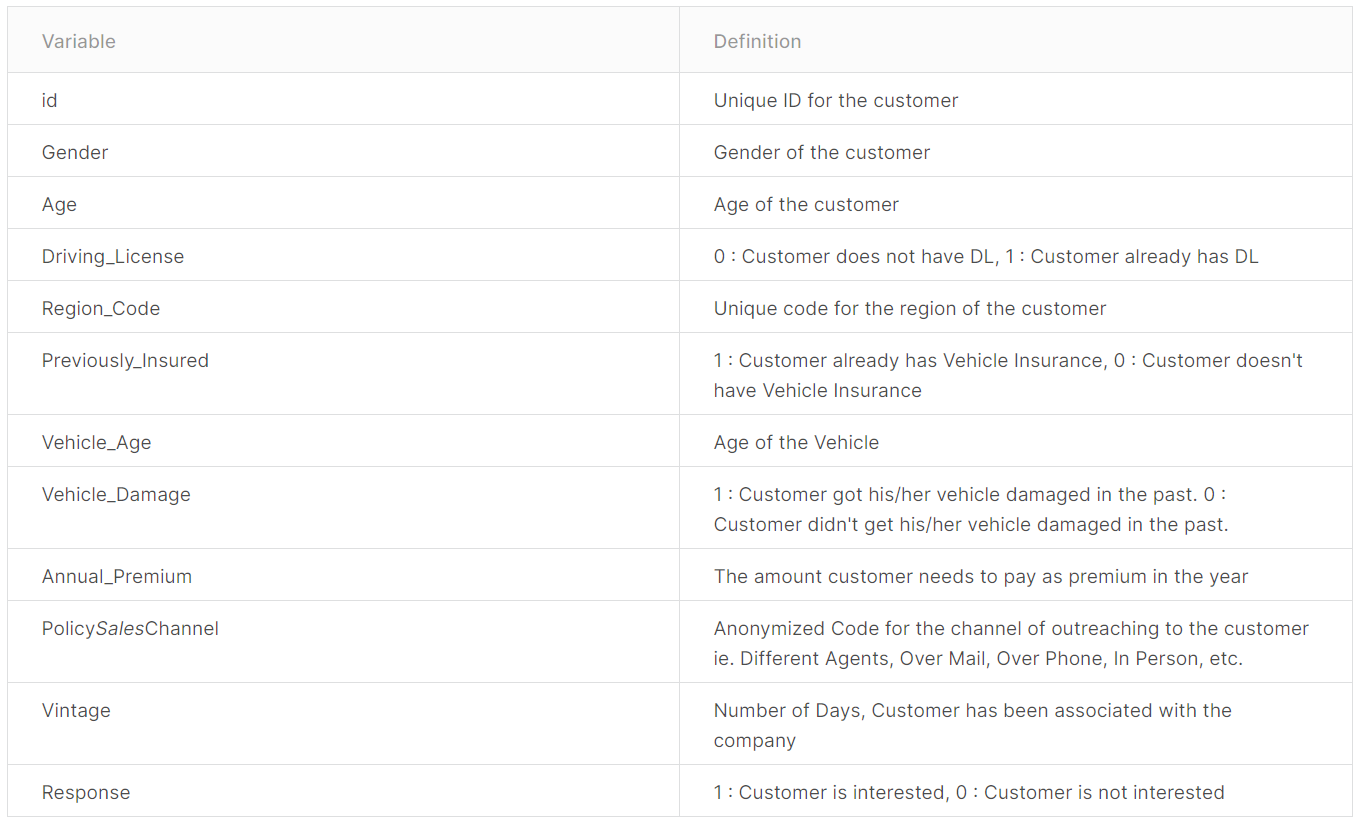

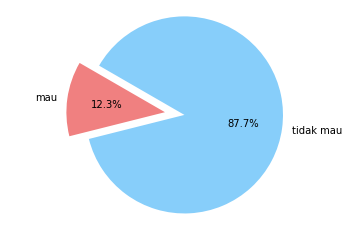

In [7]:
#ini code untuk menghitung jumlah class dependent/respond 1 dan 0
total1 = 0
total0 = 0
for i in pima.iloc[:,-1]: 
  if i==0: total0+=1
  else: total1+=1

#ini code untuk menampilkan hasilnya
import matplotlib.pyplot as plt

# Data to plot
labels = 'mau', 'tidak mau'
sizes = [total1, total0]
colors = ['lightcoral', 'lightskyblue']
explode = (0.2, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', startangle=150)

plt.axis('equal')
plt.show()

Karena tidak seimbang antara class dependent/Respond 'Mau' dan 'Tidak Mau', maka sebaiknya kita seimbangkan sebelum memasukkan dalam proses training dan testing. <br> 
karena jika tidak, maka bisa saja akan bias dalam prediksinya, akurasinya juga bisa bias karena yang di training dan testing kebanyakan 'tidak mau'.

In [8]:
response1x = []
response1y = [1 for i in range(10000)] #Disini akan membuat array yang berisi 1 sebanyak 10000
#karena response1x adalah array yang response nya 1 (mau untuk membeli asuransi)

response0x = []
response0y = [0 for i in range(10000)] #Disini akan membuat array yang berisi 0 sebanyak 10000
#karena response1x adalah array yang response nya 0 (tidak mau untuk membeli asuransi)

#Dataset yang kita punya, response yang berisi 0 jauh lebih banyak dari response yang berisi 1.
#karena itu kita akan menyeimbangkannya dengan mengambil 10000 data yang responsenya 1 dan 10000 yang 0
#karena kalau langsung dirandom, hampir pasti response 0 lebih banyak
#dan kemungkinan hasil kita nanti akan bias(cenderung hasilnya 0)

for i in range(1, 85000): #Karena jumlah respond yang 0 jauh lebih banyak dari yang 1
                          #dari 85000 data, hanya 10000an lebih yang response 1
  if (pima.Response[i]==0):
    if (len(response0x)<10000):
      response0x.append(pima.iloc[i,[1,2,3,5,6,7,8,9,10]]) # memilih column (id,region_code,response tidak ikut) 
  else:
    if (len(response1x)<10000):
      response1x.append(pima.iloc[i,[1,2,3,5,6,7,8,9,10]]) # memilih column (id,region_code,response tidak ikut)
    else:
      break

#code ini untuk menggabungkan response1x dan response0x
r1x = pd.DataFrame(response1x)
r0x = pd.DataFrame(response0x)
X = pd.concat([r1x,r0x])

r1y = pd.DataFrame(response1y)
r0y = pd.DataFrame(response0y)
y = pd.concat([r1y,r0y])

In [9]:
X

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
2,Male,47,1,0,> 2 Years,Yes,38294.0,26.0,27
7,Female,56,1,0,1-2 Year,Yes,32031.0,26.0,72
10,Female,47,1,0,1-2 Year,Yes,47576.0,124.0,46
15,Male,37,1,0,1-2 Year,Yes,2630.0,156.0,147
19,Female,60,1,0,1-2 Year,Yes,32363.0,124.0,102
...,...,...,...,...,...,...,...,...,...
11417,Male,50,1,0,1-2 Year,Yes,35252.0,26.0,54
11418,Male,33,1,1,1-2 Year,Yes,45212.0,122.0,192
11419,Male,48,1,0,1-2 Year,Yes,29725.0,29.0,279
11421,Female,28,1,1,< 1 Year,No,23709.0,152.0,149


Cuplikan Data sebelum di preprocessing

In [10]:
y

,0
0,1
1,1
2,1
3,1
4,1
...,...
9995,0
9996,0
9997,0
9998,0


seperti yang bisa dilihat diatas, class dependent/respond nya masih 1 sebanyak 10000 lalu 0 sebanyak 10000. <br>
akan kita preprocess lalu randomkan selanjutnya

In [11]:
# encode categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
X.iloc[:, 0] = labelencoder_X.fit_transform(X.iloc[:, 0]) #Encoder gender, hanya saja pakai iloc
X['Vehicle_Age'] = labelencoder_X.fit_transform(X['Vehicle_Age']) #encoder Vehicle age
X['Vehicle_Damage'] = labelencoder_X.fit_transform(X['Vehicle_Damage']) #encoder vehicle damage

#minmax scaling untuk Age, Annual_Premium,'Policy_sales Channel
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
X[['Age','Annual_Premium','Policy_Sales_Channel','Vintage']] = scaler.fit_transform(X[['Age','Annual_Premium','Policy_Sales_Channel','Vintage']])
# print(s)
# rescaledX = scaler.fit_transform(X)
# print(scaler.fit_transform([X['Age']]))


#Split dataset menjadi training set and test set
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [12]:
X_test.head(10)
# print(y_test.head(10))
# X_test.iloc[0]

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
1660,0,1.1875,1,1,1,0,1.123482,4.728395,3.588235
7438,1,2.6875,1,0,0,1,1.326654,4.037037,1.069204
26277,0,3.1875,1,0,0,1,1.421956,4.827160,4.141869
9845,1,2.9375,1,0,0,0,1.160496,4.728395,1.982699
12502,0,1.2500,1,0,1,1,1.000000,4.728395,2.467128
2931,1,1.1250,1,1,1,0,1.139548,4.728395,2.342561
6266,1,2.6875,1,0,0,1,1.000000,4.037037,2.910035
4550,0,1.2500,1,1,1,0,1.195046,4.728395,2.522491
77618,0,3.2500,1,0,0,1,1.419061,4.037037,2.162630
54149,1,2.4375,1,0,0,1,1.181227,1.617284,1.816609


In [13]:
y_test.head(10)

,0
1456,0
6528,0
3253,1
8614,0
1544,1
2568,0
5497,0
3987,0
9598,1
6668,1


Sudah terandom dengan baik

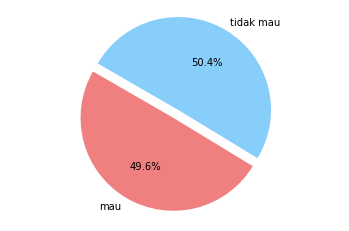

In [14]:
total1=0
total0=0
for i in y_train.iloc[:,0]:
  if (i==1):
    total1+=1
  else:
    total0+=1

# Data to plot
labels = 'mau', 'tidak mau'
sizes = [total1, total0]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', startangle=150)

plt.axis('equal')
plt.show()

data untuk di training sudah terlihat seimbang meskipun di random split

https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb#:~:text=The%20optimal%20K%20value%20usually,be%20aware%20of%20the%20outliers . <br>
Link referensi untuk hampir semua code dibawah

Maximum accuracy: 0.7993333333333333 at K = 37


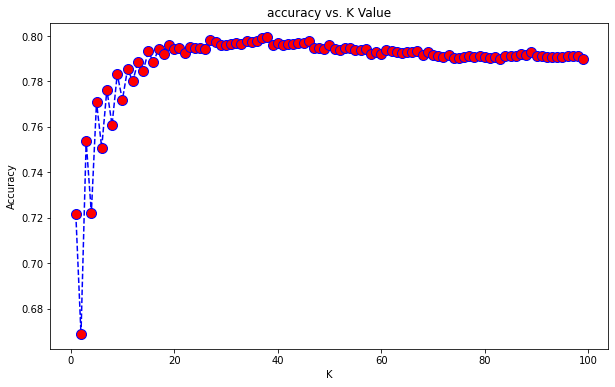

In [15]:
acc = []
# Will take some time
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
for i in range(1,100):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train.values.ravel()) #Pake values.ravel() karena ada warning error kalau tidak dipakai
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,100),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)))

ClassifierAkhir = KNeighborsClassifier(n_neighbors =acc.index(max(acc)) ).fit(X_train,y_train.values.ravel())

In [20]:
#@title Double click Untuk melihat code.<br> Apabila sudah yakin, jalankan form ini dengan ctrl+enter { display-mode: "form" }

Gender = 'Male' #@param ["Male", "Female"]
Age = 18 #@param {type:"slider", min:5, max:100, step:1}
Driving_License = True #@param {type:"boolean"}
Previously_Insured = True #@param {type:"boolean"}
Vehicle_Age = '>2 years' #@param ["<1 year", "1-2 year", ">2 years"]
Vehicle_Damage = True #@param {type:"boolean"}
Annual_Premium = 10.0 #@param {type:"number"}
Policy_Sales_Channel = 1 #@param {type:"slider", min:1, max:164, step:1}
Vintage = 10 #@param {type:"slider", min:10, max:299, step:1}




#Pre-process inputan user
#Data setelah preprocess punya '_' setelah nama

#Label Encoder Manual
if Gender=="Male": #sudah dicek, labelencoder akan mengeluarkan 1 jika male
  Gender_=1
else:
  Gender_=0

if Driving_License: #Jika punya=1
  Driving_License_=1
else:
  Driving_License_=0

if Previously_Insured:
  Previously_Insured_=1
else:
  Previously_Insured_=0

if Vehicle_Age==">2 years": #sudah dicek, jika >2 -> 2
  Vehicle_Age_=2
elif Vehicle_Age=="<1 year": #sudah dicek, jika <1 -> 1
  Vehicle_Age_=1
else:
  Vehicle_Age_=0

if Vehicle_Damage:
  Vehicle_Damage_=1
else:
  Vehicle_Damage_=0
  
#Minmax manual
#pima adalah data sebelum di preprocess
#X adalah data setelah di preprocess 
# rumus fungsi linier untuk preprocess dengan hasilnya range 1-5
                                                                         #5-1 dari range 1-5
                                                                                 #1 dari range 1-5, *minnya 1
Age_ = (((Age-min(pima['Age'])) / (max(pima['Age'])-min(pima['Age']))) * (5-1)) + 1
Annual_Premium_ = (((Annual_Premium-min(pima['Annual_Premium'])) / (max(pima['Annual_Premium'])-min(pima['Annual_Premium']))) * (5-1)) + 1
Policy_Sales_Channel_ = (((Policy_Sales_Channel-min(pima['Policy_Sales_Channel'])) / (max(pima['Policy_Sales_Channel'])-min(pima['Policy_Sales_Channel']))) * (5-1)) + 1
Vintage_ = (((Vintage-min(pima['Vintage'])) / (max(pima['Vintage'])-min(pima['Vintage']))) * (5-1)) + 1


k = ClassifierAkhir.predict([[Gender_,Age_,Driving_License_,Previously_Insured_,Vehicle_Age_,Vehicle_Damage_,Annual_Premium_,Policy_Sales_Channel_,Vintage_]])
k[0]
if k[0]==0:
  print("Berdasarkan Data yang Anda Masukkan, Model kami memprediksi bahwa customer akan '\033[1mmenolak' tawaran asuransi mobil")
else :
  print("Berdasarkan Data yang Anda Masukkan, Model kami memprediksi bahwa customer akan '\033[1mmenerima' tawaran asuransi mobil")

Berdasarkan Data yang Anda Masukkan, Model kami memprediksi bahwa customer akan 'menerima' tawaran asuransi mobil
